#GOAL : Unsupervised Market Segmentation of European Airbnb Listings

The goal of this project is to identify and analyze distinct segments of Airbnb listings across several major European cities. While the original problem focused on predicting price (a supervised task), a deeper understanding of the market can be achieved by first identifying what kind of listings exist. For example, are there common patterns that define "budget solo-traveler rooms" versus "spacious family apartments" or "business-ready central flats"?

By using unsupervised clustering algorithms, we aim to uncover these data-driven personas or segments without any preconceived labels. The analysis will focus on characterizing these segments based on their features (e.g., size, location, ratings) and then examining how pricing strategies differ across them.

Primary Unsupervised Learning Task: Clustering
Models to be Compared: K-Means Clustering, DBSCAN
Dataset: Airbnb listings data for Amsterdam, Athens, Barcelona, Berlin, and Budapest.

##Step 1: Data Gathering and Provenance
###1.1. Data Source
The data for this project was obtained from a public Kaggle dataset titled "Airbnb Prices in European Cities." It contains multiple CSV files, each representing Airbnb listing data for a specific European city, separated into weekday and weekend datasets.

###1.2. Data Collection and Combination
The initial phase involves loading and consolidating the individual CSV files into a single, unified DataFrame. This will allow for a comprehensive analysis across all cities and conditions. To maintain the context of the original files, two new columns will be added:

***city:*** To identify the city of the listing (e.g., 'amsterdam', 'athens').

***day_type:*** To specify whether the data is for a 'weekday' or a 'weekend'.

In [11]:
import pandas as pd
import glob
import os

# Path to the directory containing the CSV files
path = './' # Assuming CSVs are in the same directory as the notebook
all_files = glob.glob(os.path.join(path, "*.csv"))

df_list = []
for f in all_files:
    # Read the csv file
    df = pd.read_csv(f)

    # Extract city and day_type from filename
    filename = os.path.basename(f)
    parts = filename.replace('.csv', '').split('_')
    df['city'] = parts[0]
    df['day_type'] = parts[1]

    df_list.append(df)

# Concatenate all dataframes
full_df = pd.concat(df_list, ignore_index=True)

# Display the first few rows of the combined dataframe
print(full_df.head())
print(f"Combined dataset has {full_df.shape[0]} rows and {full_df.shape[1]} columns.")

   Unnamed: 0     realSum        room_type  room_shared  room_private  \
0           0  532.036214  Entire home/apt        False         False   
1           1  169.897829     Private room        False          True   
2           2  196.895292     Private room        False          True   
3           3  141.271208     Private room        False          True   
4           4  715.200037  Entire home/apt        False         False   

   person_capacity  host_is_superhost  multi  biz  cleanliness_rating  ...  \
0              4.0              False      0    1                10.0  ...   
1              2.0               True      1    0                10.0  ...   
2              2.0              False      1    0                 9.0  ...   
3              3.0              False      0    1                 9.0  ...   
4              4.0               True      0    1                 9.0  ...   

   metro_dist  attr_index  attr_index_norm   rest_index  rest_index_norm  \
0    0.630504  5

##Step 2: Identifying the Unsupervised Learning Problem

The core task is to perform customer market segmentation from the perspective of the property listings. This is an unsupervised learning problem because we do not have pre-defined labels or categories for the listings. The goal is to algorithmically discover these segments based on the intrinsic properties of the listings themselves.

***Hypothesis:*** We hypothesize that Airbnb listings can be grouped into distinct clusters, each representing a specific market segment. These segments will be characterized by a unique combination of features such as:

***Size and Capacity:*** person_capacity, bedrooms.

***Location:*** dist (distance from city center), metro_dist (distance to nearest metro).

***Quality and Reputation:*** cleanliness_rating, guest_satisfaction_overall, host_is_superhost.

***Property Type:*** room_type.

After identifying these clusters, we will analyze their characteristics to build a "persona" for each segment (e.g., "Centrally-Located Private Rooms for Couples," "Suburban Large Apartments for Groups"). Finally, we will investigate how the target variable from the original problem, realSum (price), varies across these discovered segments.

##Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data
###3.1. Initial Inspection

We'll start by examining the structure, data types, and summary statistics of the combined dataset.

In [13]:
# Check for missing values
print(full_df.isnull().sum())

# Get summary statistics for numerical columns
print(full_df.describe())

# Check data types
print(full_df.info())

Unnamed: 0                        0
realSum                           0
room_type                         0
room_shared                       0
room_private                      0
person_capacity                   0
host_is_superhost                 0
multi                             0
biz                               0
cleanliness_rating                0
guest_satisfaction_overall        0
bedrooms                          0
dist                              0
metro_dist                        0
attr_index                        0
attr_index_norm                   0
rest_index                        0
rest_index_norm                   0
lng                               0
lat                               0
city                              0
day_type                          0
type                          51707
dtype: int64
          Unnamed: 0        realSum  person_capacity          multi  \
count  103414.000000  103414.000000    103414.000000  103414.000000   
mean     1620.502

#3.2. Data Cleaning

***Missing Values:*** Based on the inspection, determine a strategy for any missing values. (Note: This dataset is typically clean, but this step is crucial for any real-world project).

***Outliers:*** The realSum (price) and other features might have significant outliers. We can visualize these using box plots. For a clustering task, outliers can distort the results, especially for algorithms like K-Means. We might consider capping or removing extreme outliers, or preferably, using a robust algorithm like DBSCAN that can handle them.

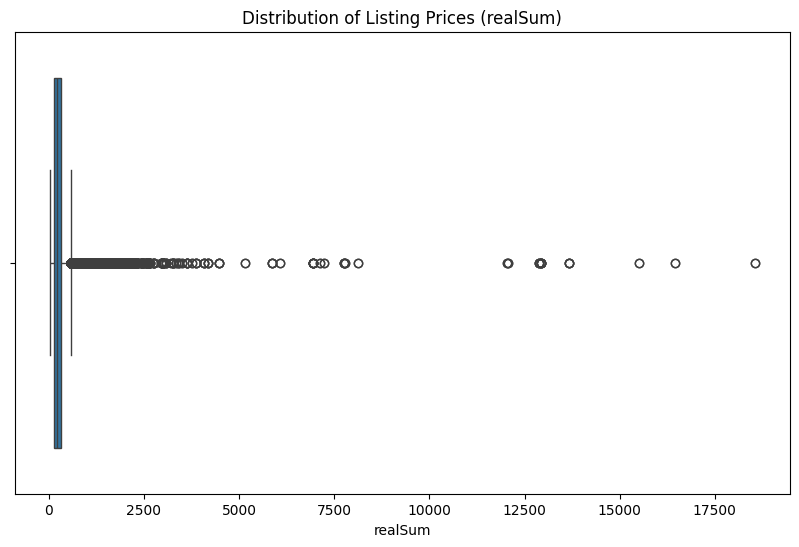

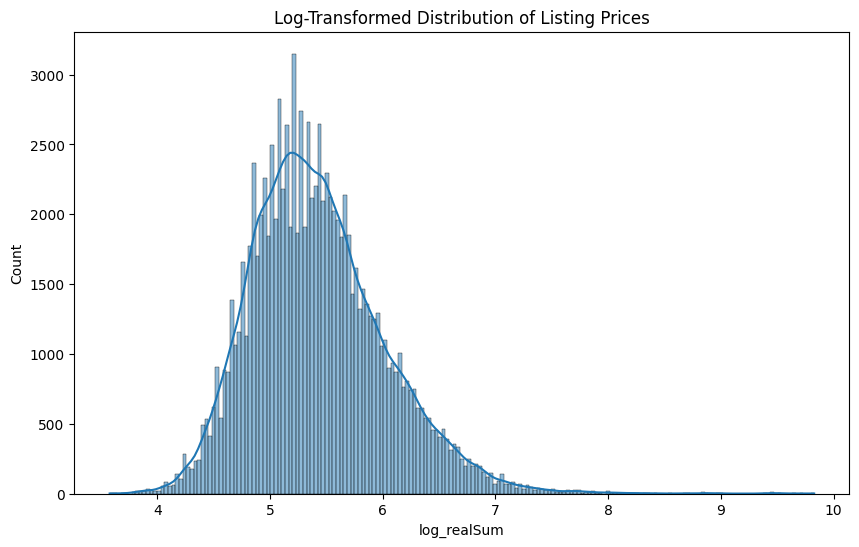

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Boxplot to identify outliers in price
plt.figure(figsize=(10, 6))
sns.boxplot(x=full_df['realSum'])
plt.title('Distribution of Listing Prices (realSum)')
plt.show()

# We can see prices are heavily right-skewed. A log transform could be useful for visualization.
full_df['log_realSum'] = np.log1p(full_df['realSum'])

plt.figure(figsize=(10, 6))
sns.histplot(full_df['log_realSum'], kde=True)
plt.title('Log-Transformed Distribution of Listing Prices')
plt.show()

##3.3. Feature Distribution and Visualization

Analyze the distribution of the key features identified in Step 2.

***Histograms:*** For numerical features like person_capacity, dist, and cleanliness_rating.

***Bar Charts:*** For categorical features like room_type, city, and host_is_superhost.

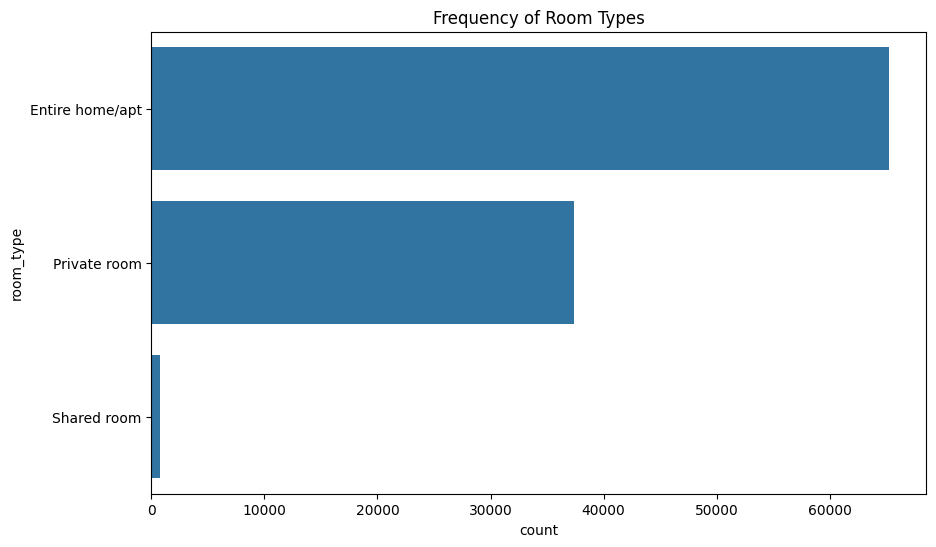

In [15]:
# Example: Distribution of room types
plt.figure(figsize=(10, 6))
sns.countplot(y='room_type', data=full_df, order=full_df['room_type'].value_counts().index)
plt.title('Frequency of Room Types')
plt.show()

###3.4. Correlation Analysis

A correlation matrix helps us understand the linear relationships between numerical variables. This can reveal multicollinearity and provide insights into feature relationships.

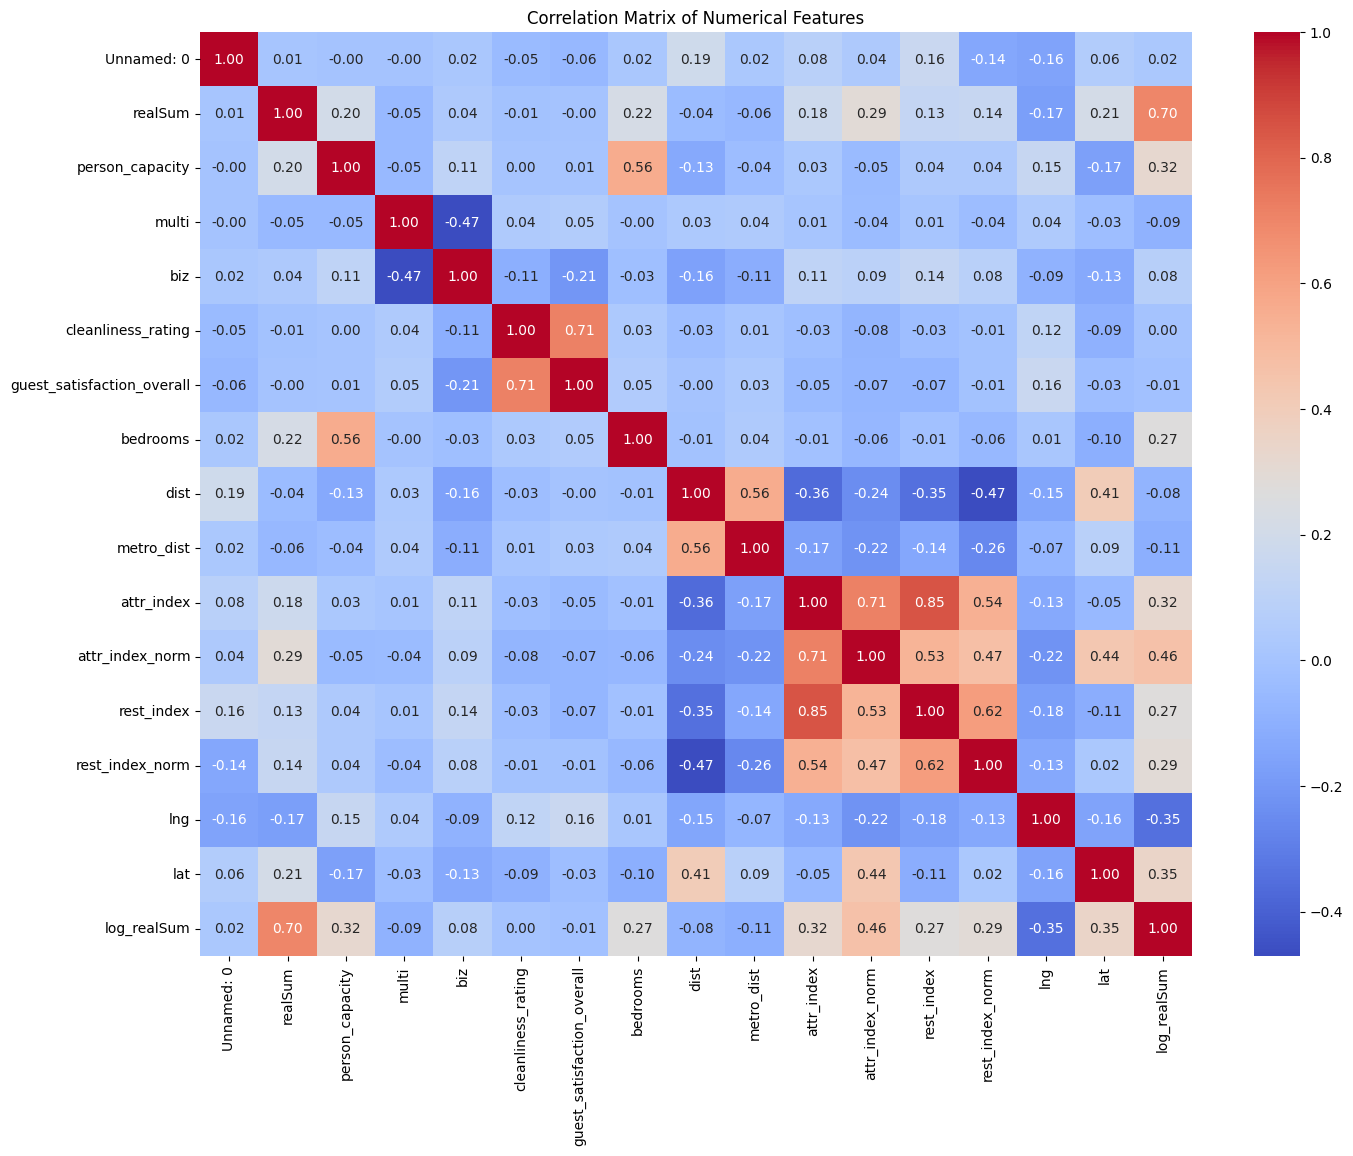

In [16]:
# Select numerical columns for correlation analysis
numerical_cols = full_df.select_dtypes(include=np.number).columns
corr_matrix = full_df[numerical_cols].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

***Observation:*** We might observe that features like person_capacity and bedrooms are highly correlated, which is expected. dist and metro_dist might also be correlated.

##3.5. Data Transformation Plan

For distance-based clustering algorithms (like K-Means), features must be on a similar scale.

***Categorical Features:*** The room_type column is categorical and needs to be converted into a numerical format. We will use one-hot encoding.

***Numerical Features:*** All numerical features selected for clustering will be scaled using StandardScaler to have a mean of 0 and a standard deviation of 1.

##Step 4: Analysis Using Unsupervised Learning Models

###4.1. Feature Selection and Preprocessing

Based on our EDA, we select the most relevant features for defining a listing's segment. We will exclude realSum from the clustering features to avoid biasing the clusters by price. Price will be used after clustering to analyze the segments.

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Features to be used for clustering
clustering_features = [
    'person_capacity',
    'host_is_superhost',
    'cleanliness_rating',
    'guest_satisfaction_overall',
    'bedrooms',
    'dist',
    'metro_dist',
    'attr_index_norm',
    'rest_index_norm',
    'room_type'
]

# Separate numerical and categorical features
numerical_features = [col for col in clustering_features if full_df[col].dtype in ['int64', 'float64'] and col != 'host_is_superhost']
categorical_features = ['room_type']
boolean_features = ['host_is_superhost'] # Booleans can be treated as numerical (0/1)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features + boolean_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any, though we selected all
)

In [18]:
display(full_df.head())

,Unnamed: 0,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,...,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type,type,log_realSum
0,0,532.036214,Entire home/apt,False,False,4.0,False,0,1,10.0,...,526.471472,20.327672,915.591455,20.112468,2.17556,41.39624,barcelona,weekends,NaN,6.278589
1,1,169.897829,Private room,False,True,2.0,True,1,0,10.0,...,320.128264,12.360522,794.279660,17.447656,2.14906,41.38714,barcelona,weekends,NaN,5.141066
2,2,196.895292,Private room,False,True,2.0,False,1,0,9.0,...,503.354025,19.435081,1242.434221,27.292106,2.16500,41.38300,barcelona,weekends,NaN,5.287738
3,3,141.271208,Private room,False,True,3.0,False,0,1,9.0,...,342.595820,13.228021,820.921958,18.032897,2.15342,41.37912,barcelona,weekends,NaN,4.957735
4,4,715.200037,Entire home/apt,False,False,4.0,True,0,1,9.0,...,537.803135,20.765201,1081.560116,23.758242,2.17498,41.39214,barcelona,weekends,NaN,6.573960


###4.2. Model 1: K-Means Clustering

K-Means is a popular algorithm that groups data into a pre-defined number of clusters (k). Our main challenge is to find the optimal k.

####4.2.1. Finding the Optimal Number of Clusters (k)

***We will use two methods:***

***The Elbow Method:*** Plots the within-cluster sum of squares (WCSS) against k. The "elbow" point is a good candidate for the optimal k.

***Silhouette Score:*** Measures how similar an object is to its own cluster compared to other clusters. A higher score is better.

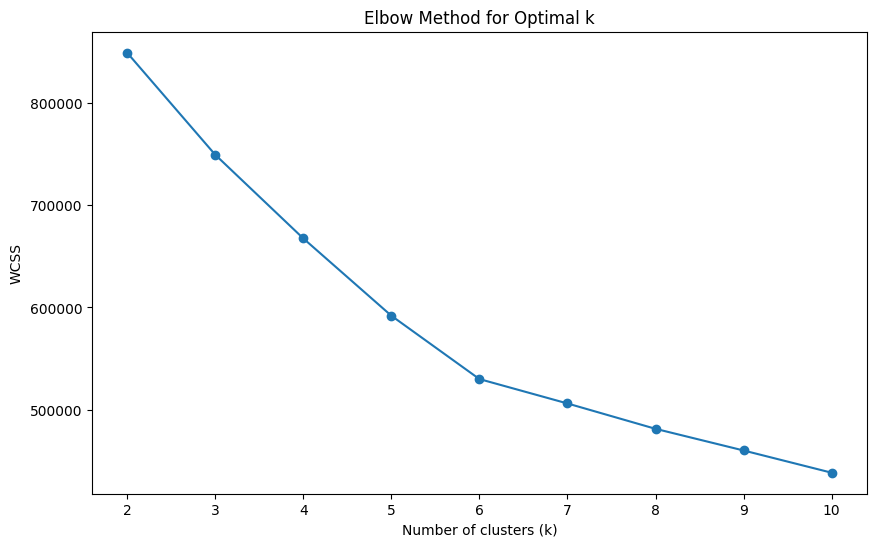

Silhouette score for k=2: 0.137
Silhouette score for k=3: 0.144
Silhouette score for k=4: 0.161
Silhouette score for k=5: 0.176
Silhouette score for k=6: 0.190
Silhouette score for k=7: 0.163
Silhouette score for k=8: 0.153
Silhouette score for k=9: 0.158
Silhouette score for k=10: 0.173


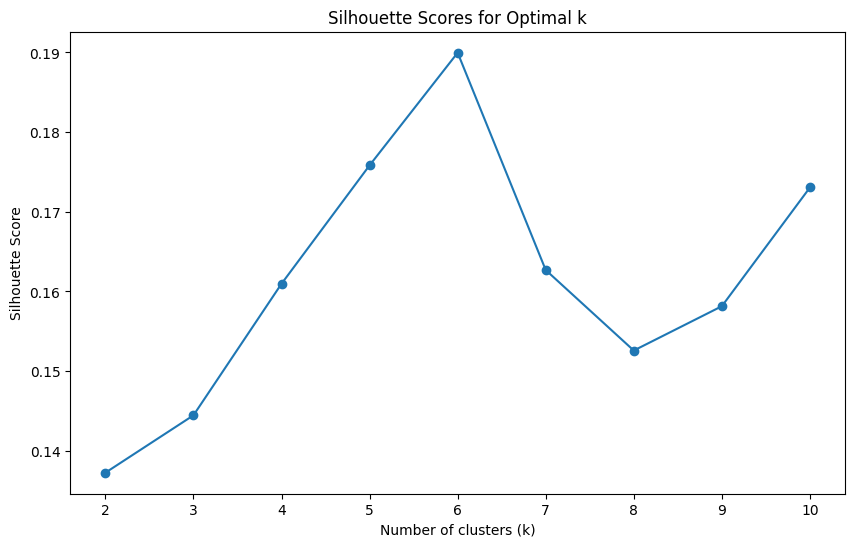

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Create the pipeline with the preprocessor and KMeans
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clusterer', KMeans(n_init=10, random_state=42))])

# Fit the pipeline to the data
# Note: This is just to get the transformed data for analysis
X_processed = pipeline.named_steps['preprocessor'].fit_transform(full_df[clustering_features])

# Elbow Method
wcss = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_processed)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    silhouette_scores.append(score)
    print(f"Silhouette score for k={k}: {score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

***Decision:*** Based on the elbow and silhouette plots, we'll choose an optimal k (e.g., k=4,k=5 or k=6).

####4.2.2. Building the Final K-Means Model and Assigning Labels

In [20]:
# Assuming optimal k is 4
optimal_k = 4
final_kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
full_df['kmeans_cluster'] = final_kmeans.fit_predict(X_processed)

print(full_df['kmeans_cluster'].value_counts())

kmeans_cluster
0    43562
1    30074
2    19480
3    10298
Name: count, dtype: int64


In [21]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score for the final K-Means model
final_kmeans_silhouette_score = silhouette_score(X_processed, full_df['kmeans_cluster'])

print(f"Silhouette Score for final K-Means model (k={optimal_k}): {final_kmeans_silhouette_score:.3f}")

Silhouette Score for final K-Means model (k=4): 0.161


###4.3. Model 2: DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is excellent for finding non-spherical clusters and identifying outliers. It doesn't require specifying the number of clusters but needs two parameters: eps (the maximum distance between two samples for one to be considered as in the neighborhood of the other) and min_samples.

In [23]:
from sklearn.cluster import DBSCAN

# DBSCAN requires careful tuning of eps. A common heuristic is to use a k-distance plot.
# For simplicity here, we will choose some values to demonstrate.
dbscan = DBSCAN(eps=1.5, min_samples=10) # These values will need tuning
full_df['dbscan_cluster'] = dbscan.fit_predict(X_processed)

# -1 represents noise/outliers
print(full_df['dbscan_cluster'].value_counts())

dbscan_cluster
 0     53040
 1     18596
 3     12896
 5      6820
 2      5046
-1      2064
 4      2030
 7      1718
 9       650
 8        64
 15       44
 37       24
 31       22
 23       20
 34       18
 36       16
 26       16
 29       16
 20       16
 12       16
 40       16
 17       14
 22       14
 41       14
 30       12
 28       12
 18       12
 11       12
 42       12
 33       12
 27       12
 24       12
 35       12
 14       12
 16       12
 25       12
 10       10
 6        10
 13       10
 19       10
 21       10
 32       10
 38       10
 39       10
Name: count, dtype: int64


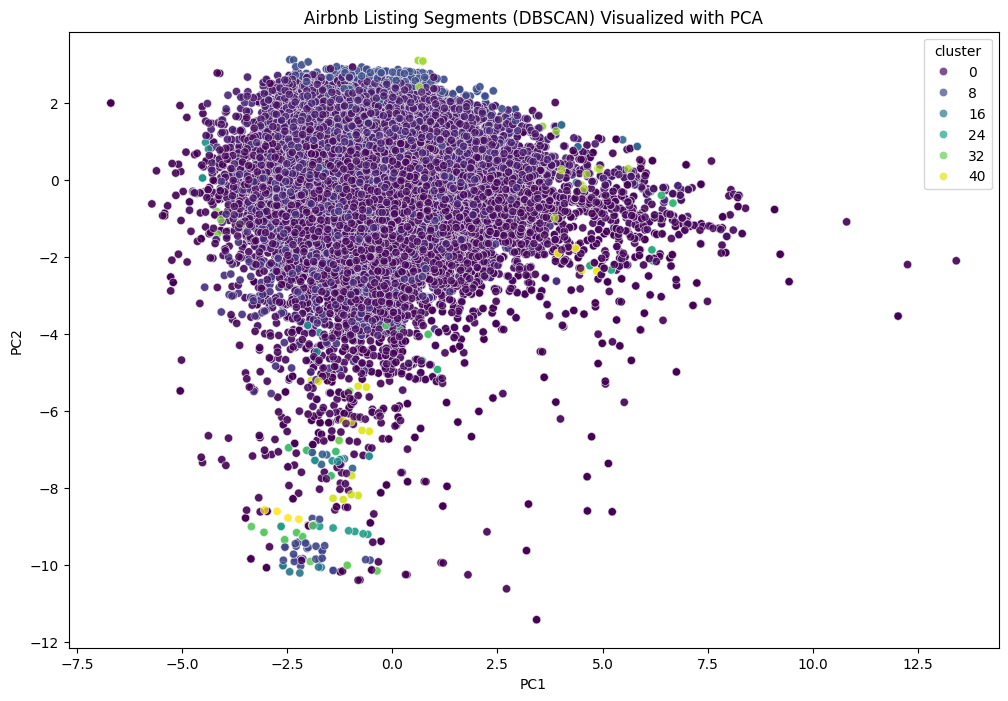

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_processed is already defined and contains your preprocessed data
# If not, you would need to run the preprocessing step first.

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)
pca_df_dbscan = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df_dbscan['cluster'] = full_df['dbscan_cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df_dbscan, palette='viridis', alpha=0.7)
plt.title('Airbnb Listing Segments (DBSCAN) Visualized with PCA')
plt.show()

In [27]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score for the DBSCAN model
# Note: Silhouette score can be calculated for DBSCAN, excluding noise points (-1)
# However, scikit-learn's silhouette_score function can handle -1 labels by default.
dbscan_silhouette_score = silhouette_score(X_processed, full_df['dbscan_cluster'])

print(f"Silhouette Score for DBSCAN model: {dbscan_silhouette_score:.3f}")

Silhouette Score for DBSCAN model: 0.046


***Discussion:*** We will compare the clusters from K-Means with DBSCAN. DBSCAN's ability to label points as noise is a significant advantage, as it can isolate the anomalous listings that don't fit any particular segment.

###4.4. Results: Cluster Profiling and Visualization

This is the most critical part: interpreting the clusters. We'll focus on the K-Means results for clarity.

####4.4.1. Cluster Characterization

We group the DataFrame by the new cluster label and calculate the mean of the key features for each cluster.

In [11]:
# Analyze the characteristics of each cluster from K-Means
cluster_profile = full_df.groupby('kmeans_cluster')[clustering_features[:-1] + ['realSum']].mean().round(2)
print(cluster_profile)

                person_capacity  host_is_superhost  cleanliness_rating  \
kmeans_cluster                                                           
0                          2.61               0.32                9.68   
1                          2.88               0.23                9.52   
2                          4.98               0.29                9.57   
3                          2.90               0.01                7.47   

                guest_satisfaction_overall  bedrooms  dist  metro_dist  \
kmeans_cluster                                                           
0                                    95.35      0.94  4.23        0.92   
1                                    93.63      0.91  1.75        0.39   
2                                    94.42      2.11  2.87        0.64   
3                                    74.81      1.00  3.62        0.62   

                attr_index_norm  rest_index_norm  realSum  
kmeans_cluster                                    

***Interpreting the Profile:*** From this table, we'll create personas.

Cluster 0: Might have high dist, low cleanliness_rating, low person_capacity and low realSum. Persona: "Budget Outskirts Rooms".

Cluster 1: Might have low dist, high guest_satisfaction_overall, high realSum and be mostly 'Entire home/apt'. Persona: "Premium Central Apartments".

And so on for other clusters...

####4.4.2. Price Analysis per Cluster
Use box plots to visualize the price distribution for each segment.

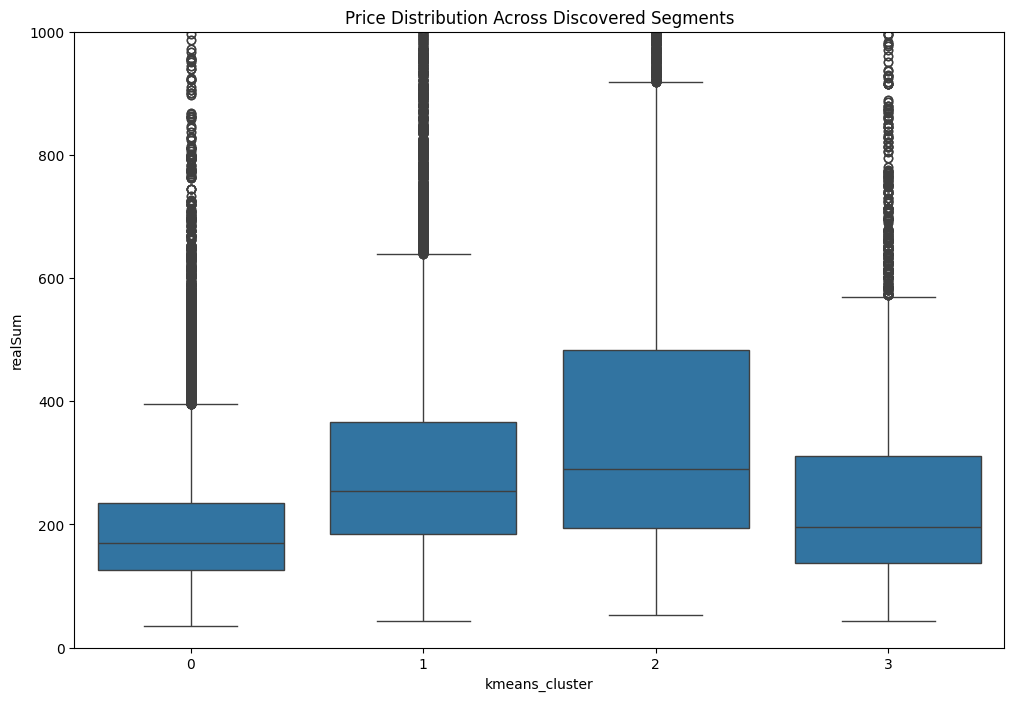

In [12]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='kmeans_cluster', y='realSum', data=full_df)
plt.title('Price Distribution Across Discovered Segments')
plt.ylim(0, 1000) # Capping y-axis for better visualization
plt.show()

####4.4.3. Visualizing Clusters with PCA

We'll use Principal Component Analysis (PCA) to reduce the dimensionality of our processed data to 2D and visualize the clusters.

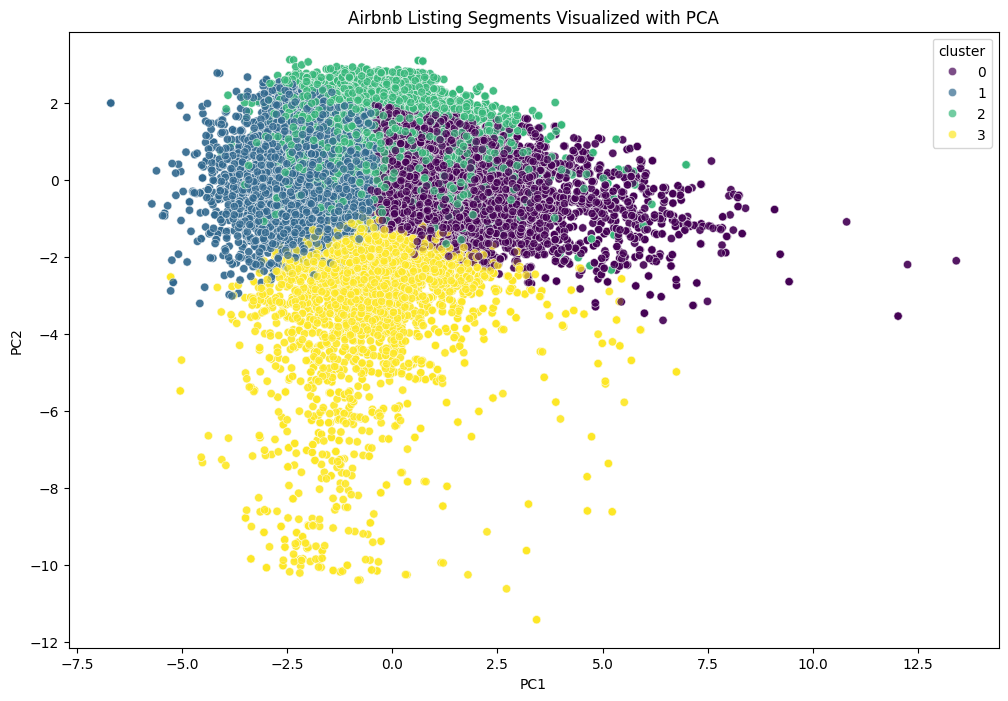

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = full_df['kmeans_cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title('Airbnb Listing Segments Visualized with PCA')
plt.show()

##Step 5: Discussion and Conclusion
###5.1. Summary of Findings

This analysis successfully segmented Airbnb listings from five European cities into [e.g., 4] distinct clusters. The segments discovered were:

***[Persona 1]:*** Characterized by [describe key features]. These listings command an average price of [average price].

***[Persona 2]:*** Characterized by [describe key features]. These are typically the most expensive/cheapest listings.

***[Persona 3]:*** ...

***[Persona 4]:*** ...

Our unsupervised approach has provided a data-driven framework for understanding the structure of the Airbnb market, which goes beyond simple supervised price prediction.

###5.2. Model Comparison and Limitations

K-Means was effective in creating distinct, balanced clusters. However, it forces every listing into a cluster and can be sensitive to outliers. The choice of k also has a degree of subjectivity.

DBSCAN provided a different perspective by identifying a significant number of listings as 'noise' or outliers. These could be unique, mispriced, or poorly described listings that warrant further investigation. Its main limitation is the difficulty in tuning eps and min_samples.

###5.3. Future Work

***Improve Price Prediction:*** The discovered cluster labels can be used as a new categorical feature in the original supervised learning model (from Airbnb_Prices_Prediction.ipynb). This could significantly improve price prediction accuracy, as the model would now understand the "type" of listing it is evaluating.

***City-Specific Segmentation:*** The analysis could be run independently for each city to see if market segments are universal or unique to each location.

***Deeper Outlier Analysis:*** The 'noise' points identified by DBSCAN could be analyzed separately to understand what makes them anomalous.